In [3]:
import numpy as np
from joblib import Parallel, delayed
import pandas as pd

import matplotlib.pyplot as plt

from torchonometrics.gmm import GMMEstimator

np.random.seed(94305)

In [4]:
def dgp(n = 100_000,
        beta = np.array([-0.5, 1.2]),
        rho = 0.7,
        pi = np.array([0.5, -0.1])):
    ε = np.random.normal(0, 1, n)
    z = np.random.normal(0, 1, n * pi.shape[0]).reshape(n, pi.shape[0])
    # Generate endogenous x, influenced by the instrument
    x = z @ pi + ε * rho + np.random.normal(0, 1, n)
    X = np.c_[np.ones(n), x]
    # heteroskedasticity
    y = X @ beta + ε + (X[:, 1] > 0) * np.random.normal(0, 1, n)
    return y, X, z

Single endogeneous variable and many instruments DGP with varying instrument strength ($\pi$) and degree of endogeneity($\rho$). Now, we vary the size of $\pi$ (and therefore increase the number of instruments) and see how the coverage rate of the GMM estimator for the structural parameter $\beta$ changes. 


## Many instruments

In [5]:
def psi(z, y, x, beta):
    return z * (y - x @ beta)[:, np.newaxis]

def onesim(seed = 42, pi = np.array([0.1,]),
           debug = False):
    np.random.seed(seed)
    true_parameter = np.array([0.2, 1.1])
    y, X, Z = dgp(n = 1_000,
                  pi = pi,
                  beta = true_parameter,
                  rho = 0.5)
    gmm = GMMEstimator(psi, backend = "torch")
    gmm.fit(np.c_[np.ones(Z.shape[0]), Z], y, X)
    confint = gmm.summary().iloc[:, -2:].values
    is_contained = (confint[:, 0] <= true_parameter) & (true_parameter <= confint[:, 1])
    if debug:
        print(np.c_[confint, true_parameter, is_contained])
    return 1. * is_contained[1]

onesim(debug = True)

[[ 0.1302  0.3648  0.2     1.    ]
 [-1.3935  1.8397  1.1     1.    ]]


/home/alal/Desktop/code/econometrics/torchonometrics/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


np.float64(1.0)

In [ ]:
def simulator(pi, nrep = 1_000):
    results = Parallel(n_jobs = -1)(delayed(onesim)(seed, pi) for seed in range(nrep))
    return np.array(results).mean()

In [ ]:
coverage_rates_strong = []
n_ins = np.arange(1, 101, 2)
for pi_length in n_ins:
    pi = np.random.rand(pi_length) # Set the value of pi for the current iteration
    coverage_rate = simulator(pi)  # Run the simulator function with the current pi
    coverage_rates_strong.append(coverage_rate)  # Append the coverage rate to the list

In [7]:
coverage_rates_weak = []
for pi_length in n_ins:
    pi = np.random.rand(pi_length)/pi_length # first stage coefs get weaker as the number of instruments increases
    coverage_rate = simulator(pi)  # Run the simulator function with the current pi
    coverage_rates_weak.append(coverage_rate)  # Append the coverage rate to the list

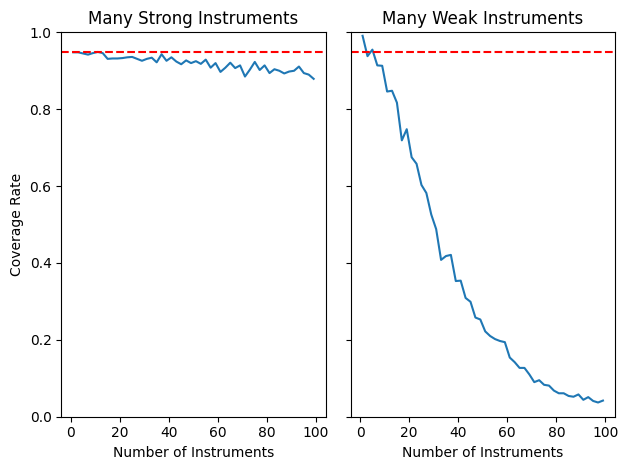

In [8]:
# Create a pandas DataFrame with the coverage rates
df_coverage = pd.DataFrame({'Number of Instruments': n_ins,
                            'Coverage Rate with Strong Instruments': coverage_rates_strong,
                            'Coverage Rate with Weak Instruments':
                            coverage_rates_weak})
f, ax = plt.subplots(1, 2, sharey=True)
df_coverage.plot(x='Number of Instruments', y='Coverage Rate with Strong Instruments', kind='line', ax = ax[0], legend = False)
df_coverage.plot(x='Number of Instruments', y='Coverage Rate with Weak Instruments', kind='line', ax = ax[1], legend = False)
ax[0].axhline(0.95, color = 'red', linestyle = '--')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Coverage Rate')
ax[0].set_title('Many Strong Instruments')
ax[1].axhline(0.95, color = 'red', linestyle = '--')
ax[1].set_ylim(0, 1)
ax[1].set_title('Many Weak Instruments')
f.tight_layout()